In [1]:
# GDRIVE_PWD = 'New folder/PANCREAS'

# try:
#     from google.colab import drive
#     import os
#     IN_COLAB = True
# except:
#     IN_COLAB = False
    
# if IN_COLAB:
#     drive.mount('/content/gdrive', force_remount=True)

import os

# pwd = "C:/Users/karti/Desktop"
# root_dir = "/New folder/PANCREAS"
# base_dir = os.path.join(pwd, root_dir)
base_dir = os.getcwd() + '/correct_PANCREAS_dataset'

In [2]:
# autoencoder = "/content/gdrive/My Drive/New folder/autoencoder.h5"

In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
# !ls

In [5]:
# uploaded['autoencoder.h5']

In [6]:
# root_dir

In [7]:
base_dir

'C:\\Users\\karti\\Desktop\\Local Machine Training - AutoEncoder for Denoising/correct_PANCREAS_dataset'

In [8]:
import tensorflow.keras
from tensorflow.keras import backend as K
import numpy as np
# import os
import matplotlib.pylab as plt

In [9]:
P_MODELSAVE = 'saved_models'
P_LOGS = 'logs'
P_IMGSAVE = 'saved_images'

dirs = [P_MODELSAVE, P_LOGS, P_IMGSAVE]

for d in dirs:
    if not os.path.exists(d):
        os.makedirs(d)

In [13]:
# dataset_path = 'PANCREAS'
batch_size = 16
epochs = 10
input_shape = (128,128)
noise_factor = 1

saved_weight = os.path.join(P_MODELSAVE, 'dataweights.{epoch:02d}-{val_accuracy:.2f}.hdf5')

In [11]:
from PIL import Image as pil_image

def random_crop(img, random_crop_size):
    width, height = img.size # PIL format
    dx, dy = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img.crop((x, y, x+dx, y+dy))


def load_img_extended(path, grayscale=False, color_mode='rgb', target_size=None,
                      interpolation='nearest'):
    if grayscale is True:
        warnings.warn('grayscale is deprecated. Please use '
                      'color_mode = "grayscale"')
        color_mode = 'grayscale'
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if color_mode == 'grayscale':
        if img.mode != 'L':
            img = img.convert('L')
    elif color_mode == 'rgba':
        if img.mode != 'RGBA':
            img = img.convert('RGBA')
    elif color_mode == 'rgb':
        if img.mode != 'RGB':
            img = img.convert('RGB')
    else:
        raise ValueError('color_mode must be "grayscale", "rbg", or "rgba"')
    
    if target_size is not None:
        width_height_tuple = (target_size[1], target_size[0])
        if img.size != width_height_tuple:
            img = random_crop(img, width_height_tuple)
    return img

In [12]:
tensorflow.keras.preprocessing.image.load_img = load_img_extended

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.2],
    shear_range=0.01,
    horizontal_flip=True,
    rescale=1/255,
    fill_mode='reflect',
    data_format='channels_last')

data_flow_args = dict(
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='input')

In [16]:
def noisy_generator(batches):
    for batch_x, batch_y in batches:
        sigma = np.random.exponential(0.15)
        noise = noise_factor * np.random.normal(scale=sigma, size=batch_x.shape)
        batch_noisy = np.clip(batch_x + noise, 0, 1)
        yield (batch_noisy, batch_y)

In [15]:
# from keras.models import load_model
# AutoEncoder = load_model(uploaded['autoencoder.h5'])
# AutoEncoder = load_model(autoencoder)

In [16]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from tensorflow.keras.initializers import orthogonal


def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = layers.Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,
                      kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = layers.Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,
                               kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x



def AutoEncoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # 256 x 256
    conv1 = Conv2DLayer(inputs, 64, 3, strides=1, padding='same', block_id=1)
    conv2 = Conv2DLayer(conv1, 64, 3, strides=2, padding='same', block_id=2)
    
    # 128 x 128
    conv3 = Conv2DLayer(conv2, 128, 5, strides=2, padding='same', block_id=3)
    
    # 64 x 64
    conv4 = Conv2DLayer(conv3, 128, 3, strides=1, padding='same', block_id=4)
    conv5 = Conv2DLayer(conv4, 256, 5, strides=2, padding='same', block_id=5)
    
    # 32 x 32
    conv6 = Conv2DLayer(conv5, 512, 3, strides=2, padding='same', block_id=6)
    
    # 16 x 16
    deconv1 = Transpose_Conv2D(conv6, 512, 3, strides=2, padding='same', block_id=7)
    
    # 32 x 32
    skip1 = layers.concatenate([deconv1, conv5], name='skip1')
    conv7 = Conv2DLayer(skip1, 256, 3, strides=1, padding='same', block_id=8)
    deconv2 = Transpose_Conv2D(conv7, 128, 3, strides=2, padding='same', block_id=9)
    
    # 64 x 64
    skip2 = layers.concatenate([deconv2, conv3], name='skip2')
    conv8 = Conv2DLayer(skip2, 128, 5, strides=1, padding='same', block_id=10)
    deconv3 = Transpose_Conv2D(conv8, 64, 3, strides=2, padding='same', block_id=11)
    
    # 128 x 128
    skip3 = layers.concatenate([deconv3, conv2], name='skip3')
    conv9 = Conv2DLayer(skip3, 64, 5, strides=1, padding='same', block_id=12)
    deconv4 = Transpose_Conv2D(conv9, 64, 3, strides=2, padding='same', block_id=13)
    
    # 256 x 256
    skip3 = layers.concatenate([deconv4, conv1])
    conv10 = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid',
                       kernel_initializer=orthogonal(), name='final_conv')(skip3)

    
    return models.Model(inputs=inputs, outputs=conv10)

In [17]:
train_datagen = ImageDataGenerator(**data_gen_args)
val_datagen = ImageDataGenerator(**data_gen_args)

train_batches = train_datagen.flow_from_directory(
    base_dir + '/train_images',
    **data_flow_args)

val_batches = val_datagen.flow_from_directory(
    base_dir + '/train_images',
    **data_flow_args)


train_noisy_batches = noisy_generator(train_batches)
val_noisy_batches = noisy_generator(val_batches)

Found 17000 images belonging to 81 classes.
Found 17000 images belonging to 81 classes.


In [18]:
# !pip install keras-adabound

In [19]:
from tensorflow.keras.optimizers import SGD, Adam

model = AutoEncoder((*input_shape, 3))
model_opt = Adam(lr=0.002)

model.compile(optimizer=model_opt, loss='mse', metrics=['accuracy'])

In [20]:
modelchk = tensorflow.keras.callbacks.ModelCheckpoint(saved_weight, 
                                      monitor='val_accuracy', 
                                      verbose=1,
                                      save_best_only=True, 
                                      save_weights_only=False,
                                      mode='auto',
                                      period=2)

tensorboard = tensorflow.keras.callbacks.TensorBoard(log_dir=P_LOGS,
                                          histogram_freq=0,
                                          write_graph=True,
                                          write_images=True)

csv_logger = tensorflow.keras.callbacks.CSVLogger(f'{P_LOGS}/keras_log.csv',
                                       append=True)

In [21]:
# model.fit_generator(train_noisy_batches,
#                     steps_per_epoch = train_batches.samples // batch_size,
#                     epochs=epochs,
#                     verbose=1, 
#                     validation_data=val_noisy_batches,
#                     validation_steps = train_batches.samples // batch_size,
#                     callbacks=[modelchk, tensorboard, csv_logger],
#                     use_multiprocessing=True)

# model.fit_generator(train_noisy_batches,
#                     steps_per_epoch = train_batches.samples // batch_size,
#                     epochs=epochs,
#                     verbose=1, 
#                     validation_data=val_noisy_batches,
#                     validation_steps = train_batches.samples // batch_size,
#                     callbacks=[modelchk, tensorboard, csv_logger])

model.fit(train_noisy_batches,
                    steps_per_epoch = train_batches.samples // batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=val_noisy_batches,
                    validation_steps = train_batches.samples // batch_size,
                    callbacks=[modelchk, tensorboard, csv_logger])

# model.fit(train_noisy_batches,
#                     steps_per_epoch = train_batches.samples // batch_size,
#                     epochs=epochs,
#                     verbose=1, 
#                     validation_data=val_noisy_batches,
#                     validation_steps = train_batches.samples // batch_size,
#                     callbacks=[modelchk, tensorboard, csv_logger],
#                     use_multiprocessing=True)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1062 steps, validate for 1062 steps
Epoch 1/10
1062/1062 [==============================] - 676s 637ms/step - loss: 0.0065 - accuracy: 0.3592 - val_loss: 0.0050 - val_accuracy: 0.3023
Epoch 2/10
1061/1062 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.3342
Epoch 00002: val_accuracy improved from -inf to 0.18863, saving model to saved_models\dataweights.02-0.19.hdf5
1062/1062 [==============================] - 667s 628ms/step - loss: 0.0021 - accuracy: 0.3342 - val_loss: 0.0049 - val_accuracy: 0.1886
Epoch 3/10
1062/1062 [==============================] - 661s 623ms/step - loss: 0.0019 - accuracy: 0.3338 - val_loss: 0.0077 - val_accuracy: 0.4035
Epoch 4/10
1061/1062 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.3031
Epoch 00004: val_accuracy improved from 0.18863 to 0.48278, saving model to saved_models\dataweights.04-0.48.hdf5
1062/1062 [==============================] - 663s 

In [10]:
model = tensorflow.keras.models.load_model(os.path.join(P_MODELSAVE,
                                             'dataweights.04-0.48.hdf5'))

In [17]:
test_datagen = ImageDataGenerator(**data_gen_args)

test_batches = test_datagen.flow_from_directory(
    base_dir + '/test_images',
    **data_flow_args)

test_noisy_batches = noisy_generator(test_batches)

Found 226 images belonging to 1 classes.


In [18]:
X, y = next(test_noisy_batches)

In [19]:
score = model.evaluate(X, y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

16/16 [==============================] - 3s 193ms/sample - loss: 0.0014 - accuracy: 0.3891
Test loss: 0.0014227725332602859
Test accuracy: 0.38910675


In [20]:
decoded_imgs = model.predict(X)

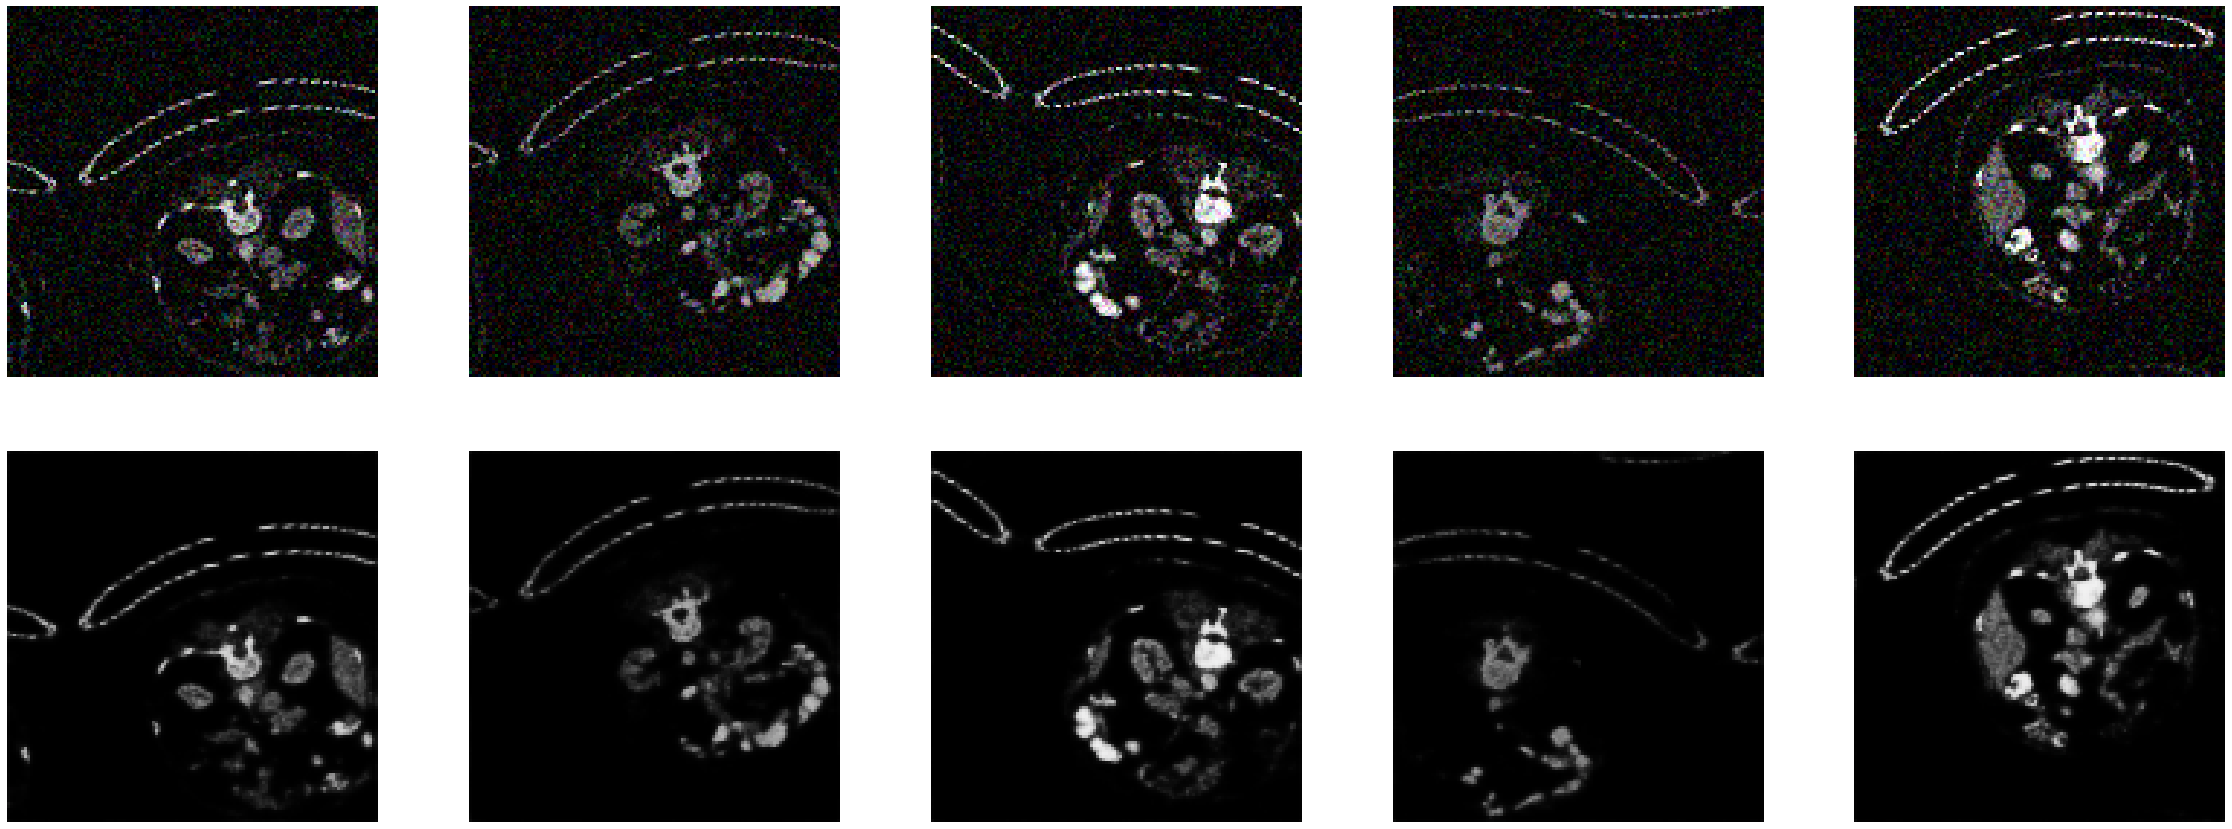

In [21]:
import matplotlib.pyplot as plt

n = 5

plt.figure(figsize=(40, 15))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X[i])
    ax.axis('off')

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    ax.axis('off')

plt.show()

In [22]:
import skimage.metrics as metrics

In [30]:
metrics.mean_squared_error(X[0], decoded_imgs[0])

0.006081204730286546

In [31]:
metrics.peak_signal_noise_ratio(X[0], decoded_imgs[0])

C:\Users\karti\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  """Entry point for launching an IPython kernel.


22.160103753511788

In [32]:
metrics.structural_similarity(X[0], decoded_imgs[0], multichannel=True)

0.3634699546073021